In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from func import calc_vpin, imbalance
from data_load import load_data
from data_processing import transform_buy_sell_volume

In [3]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
import gc
from sklearn.metrics import classification_report
from scipy.stats.stats import pearsonr

In [4]:
# Đường dẫn tới thư mục cần kiểm tra
folder_path = "req_files"
# Kiểm tra nếu thư mục chưa tồn tại thì tạo mới
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Đã tạo thư mục: {folder_path}")
else:
    print(f"Thư mục '{folder_path}' đã tồn tại.")

Thư mục 'req_files' đã tồn tại.


In [5]:
df={}; sec_trades = {}
sym = ['STB', 'SAB','MWG', 'VCB','TCB']

In [6]:
## Load data
data_tick = load_data(folder="tick")
data_orderbook = load_data(folder="orderbook")

In [7]:
# Transform data
for s in sym:
    data = data_tick[s].copy()
    data.rename(columns = {"Gia KL": "PRICE", "KL": "SIZE"}, inplace = True)
    data.set_index("Date", inplace = True)
    data = data.resample("T").agg({
            'SIZE': 'sum',  # Cột volume tính tổng
            'PRICE': 'mean'    # Cột price tính trung bình
        })
    # data.to_csv(f"req_files/{s}price.csv")
    sec_trades[s] = data

In [8]:
# Set volume
volume = {}
for key, val in sec_trades.items():
    volume[key] = int(val['SIZE'].resample("D").sum().mean()/50) # Sum của từng ngày, rồi lấy mean, rồi chia 50
volume


{'STB': 5324, 'SAB': 197, 'MWG': 2364, 'VCB': 490, 'TCB': 5012}

$$
V_{\tau}^B = \sum_{i = t(\tau - 1) + 1}^{t(\tau)} V_i \cdot Z\left(\frac{P_i - P_{i-1}}{\sigma_{\Delta P}}\right)
$$

$$
V_{\tau}^S = \sum_{i = t(\tau - 1) + 1}^{t(\tau)} V_i \cdot \left[ 1 - Z\left(\frac{P_i - P_{i-1}}{\sigma_{\Delta P}}\right) \right] = V - V_{\tau}^B
$$

$$
VPIN = \frac{\alpha \mu}{\alpha \mu + 2\varepsilon} \approx \frac{\sum_{\tau=1}^n \left| V_{\tau}^S - V_{\tau}^B \right|}{nV}.
$$


In [9]:
# Cal vpin
for s in sym:
    print('Calculating VPIN')
    df[s] = calc_vpin(sec_trades[s],volume[s],50)
    df[s].to_csv(f"req_files/{s}VPIN.csv",index = True)
    print(s+' '+str(df[s].shape))

Calculating VPIN
STB (2700, 4)
Calculating VPIN
SAB (2709, 4)
Calculating VPIN
MWG (2700, 4)
Calculating VPIN
VCB (2700, 4)
Calculating VPIN
TCB (2700, 4)


In [10]:
## Tạo avg df, với từng cột chứa phân vị (giá trị từ 0 đến 1) của các giá trị trong cột VPIN của từng stock
avg = pd.DataFrame()
print(avg.shape)
metric = 'CDF'
avg[metric] = np.nan # Tạo cột này để những cột CDF phía sau sẽ có hậu tố, cột này không có ý nghĩa
for stock,frame in df.items():
    frame = frame[[metric]].reset_index().drop_duplicates(subset='Time', keep='last').set_index('Time')
    avg = avg.merge(frame[[metric]],left_index=True,right_index=True,how='outer',suffixes=('',stock)) #suffixes: Quy định hậu tố khi có các cột trùng tên giữa hai DataFrame.
    print(avg.shape)
avg = avg.dropna(axis=0,how='all').fillna(method='ffill')
# Xoá cột CDF tạo lúc ban đầu
avg = avg.drop(["CDF"], axis = 1)
avg.to_csv('req_files/CDF.csv')

(0, 0)
(2032, 2)
(2995, 3)
(4106, 4)
(4784, 5)
(5276, 6)


In [11]:
# Tạo fields tổng quát hơn
fields = list(avg.columns)
fields.append("Time")
fields

['CDFSTB', 'CDFSAB', 'CDFMWG', 'CDFVCB', 'CDFTCB', 'Time']

### Mean Correlation at time
$$
\text{Mean Correlation at time } t = \frac{\sum_{i=1}^{n} \sum_{j=1}^{n} r_{ij}(t)}{n^2}
$$


In [12]:
df = pd.read_csv('req_files/CDF.csv',parse_dates=['Time'],index_col=[0],usecols = fields)
rolling_pariwise_corr = df.rolling(window=50).corr()

thres = pd.DataFrame()
thres['AvgCorrAssets'] = rolling_pariwise_corr.groupby(by=['Time']).sum().sum(axis=1)/((len(fields)-1)**2)
thres.to_csv('req_files/AvgCorrAssets.csv')

In [13]:
STB = transform_buy_sell_volume(data_dict=data_orderbook, key1 = "STB")

In [14]:
STB.rename(columns = {
    "Gia_Mua": "BID",
    "KL_mua": "BIDSIZ",
    "Gia_Ban": "ASK",
    "KL_ban": "ASKSIZ"
    }, inplace = True)
STB.set_index("Date", inplace=True)

In [15]:
quote_imb=imbalance(STB)
quote_imb.to_csv('req_files/imbalance.csv')

In [16]:
sec_trades = data_tick["STB"]
print('File read complete')

File read complete


## Applying Theory Based and ML Based Trading Strategies

In [ ]:
df_corr_assets = pd.read_csv('req_files/AvgCorrAssets.csv',parse_dates=['Time'],index_col='Time')
df_vpin = pd.read_csv('req_files/STBVPIN.csv',parse_dates=['Time'],usecols=['Time','CDF'],index_col='Time')
df_quote_imb = pd.read_csv('req_files/imbalance.csv',parse_dates=['Date'],index_col='Date')
df_quote_imb.index.name = 'TIME'
df_price = pd.read_csv('req_files/STBprice.csv')[["Date", "PRICE"]]
df_price.index.name = 'Date'

In [18]:
total_df = pd.DataFrame()
frame = df_corr_assets[[df_corr_assets.columns[0]]].reset_index().drop_duplicates(subset='Time', keep='last').set_index('Time')
total_df = total_df.merge(frame[[frame.columns[0]]],left_index=True,right_index=True,how='outer')
print (total_df.shape)

frame = df_vpin[[df_vpin.columns[0]]].reset_index().drop_duplicates(subset='Time', keep='last').set_index('Time')
total_df = total_df.merge(frame[[frame.columns[0]]],left_index=True,right_index=True,how='outer')
print (total_df.shape)

frame = df_quote_imb[[df_quote_imb.columns[0]]].reset_index().drop_duplicates(subset='TIME', keep='last').set_index('TIME')
total_df = total_df.merge(frame[[frame.columns[0]]],left_index=True,right_index=True,how='outer')
print (total_df.shape)

frame = df_price.drop_duplicates(subset='Date', keep='last').set_index('Date')
total_df = total_df.merge(frame[[frame.columns[0]]],left_index=True,right_index=True,how='outer')
print (total_df.shape)

total_df = total_df.dropna(axis=0,how='all').fillna(method='ffill').fillna(method='bfill')
total_df = total_df.dropna(how='any')
print (total_df.shape)

(5204, 1)
(5220, 2)
(76410, 3)
(152820, 4)
(83212, 4)


In [19]:
total_df.to_csv('req_files/data_qlearner.csv')

In [20]:
df = total_df.copy()
df.index.name = "Time"
df.head()

,AvgCorrAssets,CDF,quote_imb,PRICE
Time,,,,
2024-09-23 13:00:00,0.0,0.028291,-391120.0,30.941667
2024-09-23 13:01:00,0.0,0.028291,-68310.0,30.941667
2024-09-23 13:02:00,0.0,0.028291,-623890.0,30.941667
2024-09-23 13:03:00,0.0,0.028291,-623890.0,30.941667
2024-09-23 13:04:00,0.0,0.028291,-124940.0,30.941667


In [21]:
df['returns']=df['PRICE'].pct_change()
df['returns']=df['returns'].shift(-1)
df=df.replace([np.inf, -np.inf], np.nan)
df=df.ffill()
df = df[:-1]
df.index = pd.to_datetime(df.index)
df=df.between_time('8:00','16:00')
df=df[df.index.dayofweek < 5]
df.to_csv('new_data.csv')

savg=df[['AvgCorrAssets','quote_imb']].rolling(window=100).mean()
sstd=df[['AvgCorrAssets','quote_imb']].rolling(window=100).std()

In [22]:
zcorras=(df['AvgCorrAssets']-savg['AvgCorrAssets'])/sstd['AvgCorrAssets']
zimb=(df['quote_imb']-savg['quote_imb'])/sstd['quote_imb']
zcorras[zcorras>3]=3
zcorras[zcorras<-3]=-3
zimb[zimb>3]=3
zimb[zimb<-3]=-3

df_trading=pd.DataFrame({'price':df['PRICE'][100:],'cdf':df['CDF'][100:],'zcorras':zcorras[100:],'zimb':zimb[100:],'returns':df['returns'][100:], 'Time':df.index[100:]}
                        ).set_index('Time')
df_trading.to_csv('final.csv')

In [23]:
pos=pd.DataFrame(columns=['position','returns','Time'])
position=0

for index,row in df_trading.iterrows():
    if(row['cdf']>0.5 and row['zcorras']>2):
        if(row['zimb']>1.5):
            if(position<0):
                position=0
            position+=0.1
            bcount=10
        if(row['zimb']<-1.5):
            if(position>0):
                position=0
            position-=0.1
            scount=10
    if(position>0):
        bcount=bcount-1
        if(bcount==0):
            position=0
    elif(position<0):
        scount=scount-1
        if(scount==0):
            position=0
    pos = pd.concat([pos, pd.DataFrame([{'position':position,'returns':row['returns'], 'price':row['price'],'Time':index}])])
pos=pos.set_index('Time')
pos['wealth']=(1+pos['returns']*pos['position']).cumprod()

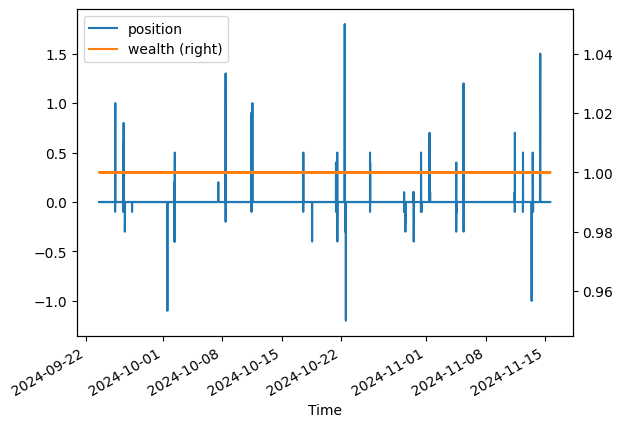

In [24]:
ax=pos[['position','wealth']].plot(secondary_y=['wealth'])

### Applying ML Classification Based Strategies

In [25]:
df= df_trading.copy()
df=df[df['zcorras'].notnull()]
number = int(df.shape[0]*0.7)

In [26]:
X = df[['cdf','zcorras','zimb']]
y=(df['returns']>0).astype(int)

# Split the data into training/testing sets
df_X_train = X[:number]
df_X_test = X[number:]

# Split the targets into training/testing sets
df_y_train = y[:number]
df_y_test = y[number:]

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4582
           1       0.00      0.00      0.00        33

    accuracy                           0.99      4615
   macro avg       0.50      0.50      0.50      4615
weighted avg       0.99      0.99      0.99      4615



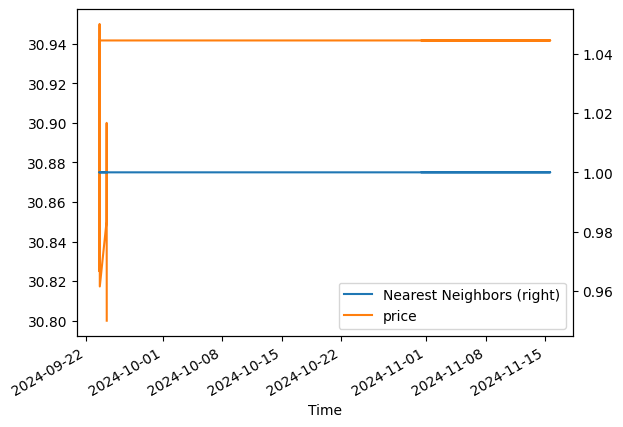

Failed:  SVC(C=0.025, kernel='linear') Linear SVM
Failed:  SVC(C=1, gamma=0.25) RBF SVM
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4582
           1       0.00      0.00      0.00        33

    accuracy                           0.99      4615
   macro avg       0.50      0.50      0.50      4615
weighted avg       0.99      0.99      0.99      4615



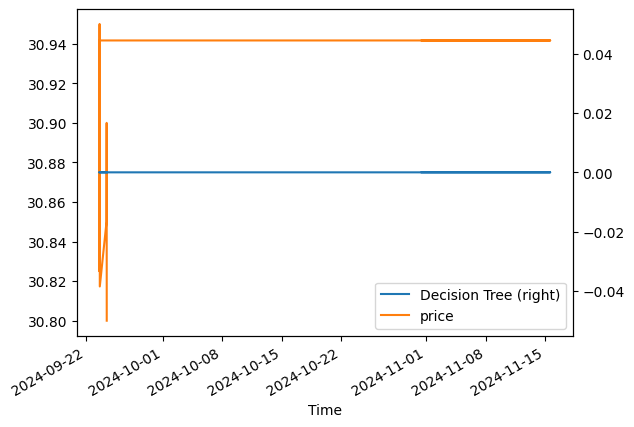

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4582
           1       0.00      0.00      0.00        33

    accuracy                           0.99      4615
   macro avg       0.50      0.50      0.50      4615
weighted avg       0.99      0.99      0.99      4615



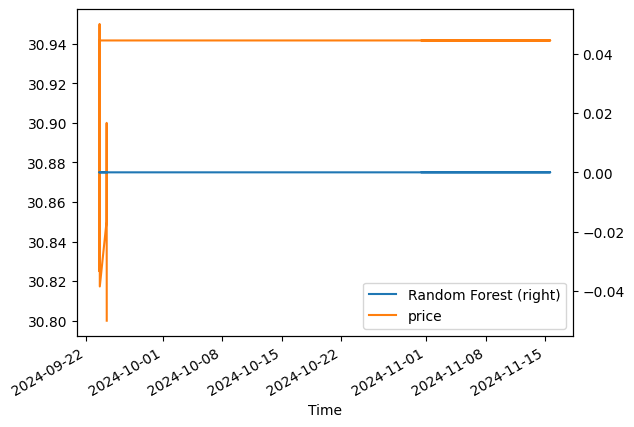

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4582
           1       0.00      0.00      0.00        33

    accuracy                           0.99      4615
   macro avg       0.50      0.50      0.50      4615
weighted avg       0.99      0.99      0.99      4615



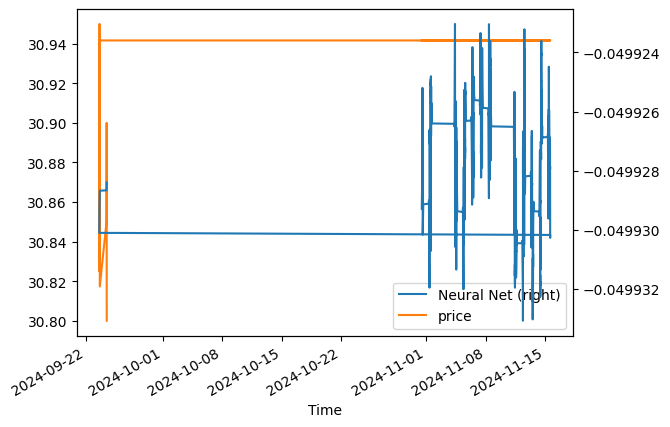

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4582
           1       0.00      0.00      0.00        33

    accuracy                           0.99      4615
   macro avg       0.50      0.50      0.50      4615
weighted avg       0.99      0.99      0.99      4615



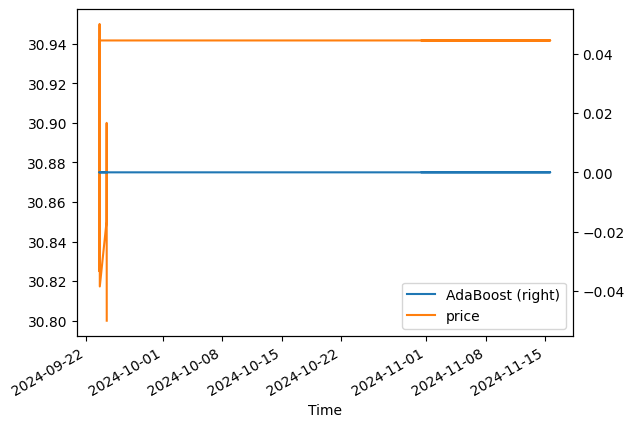

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4582
           1       0.00      0.00      0.00        33

    accuracy                           0.99      4615
   macro avg       0.50      0.50      0.50      4615
weighted avg       0.99      0.99      0.99      4615



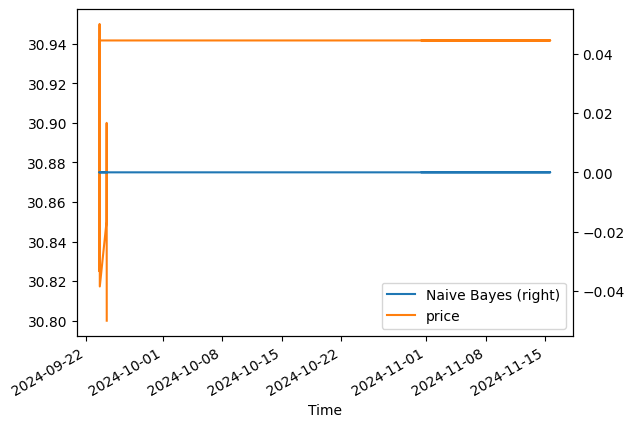

Failed:  QuadraticDiscriminantAnalysis() QDA


In [27]:
score=[]
pos=None
classifiers = [
    KNeighborsClassifier(4),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=0.25, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=4),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

for cla,name in zip(classifiers,names): 
    try:
        clf=cla
        clf.fit(df_X_train, df_y_train)
        score.append(accuracy_score(df_y_test,clf.predict(df_X_test)))
        position=((clf.predict_proba(df_X_test))*[-0.05,0.05]).sum(axis=1)
        print(classification_report(df_y_test, clf.predict(df_X_test)))
        wealth=(1+df['returns'][number:]*position).cumprod()
        if(pos is None):
            pos=pd.DataFrame({'returns':df['returns'][number:], name:wealth,'price':df['price'][number:],'Time':df.index[number:]}).set_index('Time')
        else:
            pos[name]=position
        ax=pos[[name,'price']].plot(secondary_y=[name])
        plt.show()
        gc.collect()
    except:
        print("Failed: ",cla, name)
        pass